In [1]:
import os
import shutil
import numpy as np
import h5py
import matplotlib.pyplot as plt
plt.rc('font', size=12.0)

import tensorflow as tf
from keras import layers
import keras_tuner as kt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler

2024-11-14 13:38:05.429640: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-11-14 13:38:05.438833: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-11-14 13:38:05.441601: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [2]:
model = ['nl']
label = ['NL']
x_names = ['a', 'alpha', 'param_S', 'param_L', '', 'trans1', '', 'trans2', '']
for k in range(len(model)):
    if model[k] == 'mp' or model[k] == 'np':
        x_names[4], x_names[6], x_names[8] = 'exp1', 'exp2', 'exp3'
    else:
        x_names[4], x_names[6], x_names[8] = 'csq1', 'csq2', 'csq3'

dir = '/home/anik/bamr/out/aff_inv/'
mchain = h5py.File(dir + 'nl_all', 'r')['markov_chain_0']

x_ncols = len(x_names)
nrows, data = mchain['nlines'][0], mchain['data']
X = np.zeros((x_ncols, nrows))

for i in range(x_ncols):
    X[i] = data[x_names[i]]
Y = np.array(data['M_max']).reshape(-1, 1)

X = X.T

scaler_X = MinMaxScaler(feature_range=(0, 1))
scaler_Y = MinMaxScaler(feature_range=(0, 1))

x = scaler_X.fit_transform(X)
y = scaler_Y.fit_transform(Y)

x_tr, x_ts, y_tr, y_ts = train_test_split(x, y, test_size=0.2, random_state=42)
x_ts, x_vl, y_ts, y_vl = train_test_split(x_ts, y_ts, test_size=0.01, random_state=42)

In [3]:
tuner_dir = 'trials2'

if os.path.exists(tuner_dir):
    shutil.rmtree(tuner_dir)

gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        tf.config.experimental.set_memory_growth(gpus[0], True)
        print("Memory growth enabled for the first GPU.")
    except RuntimeError as e:
        print(f"Could not enable memory growth: {e}")
else:
    print("No GPUs found.")

Memory growth enabled for the first GPU.


I0000 00:00:1731609487.369378 3384170 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
I0000 00:00:1731609487.441254 3384170 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
I0000 00:00:1731609487.442473 3384170 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355


In [4]:
def build_model(hp):

    model = tf.keras.Sequential()
    model.add(layers.Input(shape=(9,)))
    
    for i in range(hp.Int('num_layers', 2, 3)):
        units = hp.Choice(f'units_{i}', [8, 16, 32, 48, 64])
        model.add(layers.Dense(units=units, activation='relu'))
    
    model.add(layers.Dense(units=1, activation='sigmoid'))
    
    model.compile(
        optimizer='adam',
        loss='mse',
        metrics=['mse']
    )
    
    return model

tuner = kt.RandomSearch(
    build_model,
    objective='val_loss',
    max_trials=1000,
    executions_per_trial=1,
    directory='trials2',
)

tuner.search_space_summary()

I0000 00:00:1731609487.453467 3384170 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
I0000 00:00:1731609487.455241 3384170 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
I0000 00:00:1731609487.456481 3384170 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
I0000 00:00:1731609487.564712 3384170 cuda_executor.cc:1015] successful NUMA node read from SysFS ha

Search space summary
Default search space size: 3
num_layers (Int)
{'default': None, 'conditions': [], 'min_value': 2, 'max_value': 3, 'step': 1, 'sampling': 'linear'}
units_0 (Choice)
{'default': 8, 'conditions': [], 'values': [8, 16, 32, 48, 64], 'ordered': True}
units_1 (Choice)
{'default': 8, 'conditions': [], 'values': [8, 16, 32, 48, 64], 'ordered': True}


In [5]:
early_stop = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    restore_best_weights=True,
    patience=10
)

lr_schedule = tf.keras.callbacks.ReduceLROnPlateau(
    monitor='val_loss', 
    factor=0.1, 
    patience=5
)

tuner.search(
    x_tr, y_tr,
    validation_data=(x_ts, y_ts),
    epochs=100,
    batch_size=128,
    callbacks=[early_stop]
)

Trial 212 Complete [00h 00m 13s]
val_loss: 0.0013294899836182594

Best val_loss So Far: 0.00011330779670970514
Total elapsed time: 00h 44m 59s


In [6]:
tuner.results_summary(num_trials=10)

Results summary
Results in trials2/untitled_project
Showing 10 best trials
Objective(name="val_loss", direction="min")

Trial 0130 summary
Hyperparameters:
num_layers: 3
units_0: 48
units_1: 64
units_2: 64
Score: 0.00011330779670970514

Trial 0013 summary
Hyperparameters:
num_layers: 3
units_0: 64
units_1: 64
units_2: 48
Score: 0.0001194178475998342

Trial 0205 summary
Hyperparameters:
num_layers: 3
units_0: 48
units_1: 48
units_2: 64
Score: 0.00012411274656187743

Trial 0070 summary
Hyperparameters:
num_layers: 3
units_0: 64
units_1: 64
units_2: 64
Score: 0.00013791819219477475

Trial 0078 summary
Hyperparameters:
num_layers: 3
units_0: 32
units_1: 64
units_2: 64
Score: 0.00013826611393596977

Trial 0056 summary
Hyperparameters:
num_layers: 3
units_0: 64
units_1: 64
units_2: 32
Score: 0.00014138581173028797

Trial 0090 summary
Hyperparameters:
num_layers: 3
units_0: 32
units_1: 64
units_2: 32
Score: 0.00014448574802372605

Trial 0080 summary
Hyperparameters:
num_layers: 2
units_0: 64


In [7]:
# Retrieve the best model and evaluate
best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]
best_model = tuner.hypermodel.build(best_hps)
best_model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_3 (Dense)                 │ (None, 48)             │           480 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 64)             │         3,136 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 64)             │         4,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 7,841 (30.63 KB)

 Trainable params: 7,841 (30.63 KB)

 Non-trainable params: 0 (0.00 B)

In [8]:
early_stop = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss', 
    min_delta=1.0e-6, 
    patience=10
)

lr_schedule = tf.keras.callbacks.ReduceLROnPlateau(
    monitor='val_loss', 
    factor=0.5, 
    patience=5, 
    min_lr=1e-6
)

# Optionally, retrain on the full dataset with optimal hyperparameters
training = best_model.fit(x_tr, y_tr, epochs=1000, validation_data=(x_ts, y_ts), \
                          batch_size=128, callbacks=[early_stop, lr_schedule])

Epoch 1/1000
67/67 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step - loss: 0.0459 - mse: 0.0459 - val_loss: 0.0141 - val_mse: 0.0141 - learning_rate: 0.0010
Epoch 2/1000
67/67 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0121 - mse: 0.0121 - val_loss: 0.0095 - val_mse: 0.0095 - learning_rate: 0.0010
Epoch 3/1000
67/67 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0089 - mse: 0.0089 - val_loss: 0.0068 - val_mse: 0.0068 - learning_rate: 0.0010
Epoch 4/1000
67/67 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0061 - mse: 0.0061 - val_loss: 0.0043 - val_mse: 0.0043 - learning_rate: 0.0010
Epoch 5/1000
67/67 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0036 - mse: 0.0036 - val_loss: 0.0028 - val_mse: 0.0028 - learning_rate: 0.0010
Epoch 6/1000
67/67 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0023 - mse: 0.0023 - val_loss: 0.0021 - val_mse: 0.0021 - learning_rate: 0.0010
Epoch 7/1000
67/67 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0018 - mse: 0.0018 - val_loss: 0.0017 - val_mse: 0.0017 - learning_rate: 0.0010
Epoch

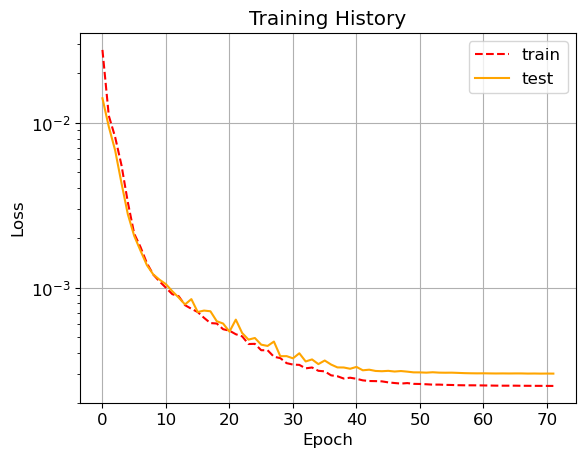

In [9]:
plt.semilogy(training.history['loss'], ls='--', color='red', label='train')
plt.semilogy(training.history['val_loss'], color='orange', label='test')
plt.grid()
plt.ylabel("Loss")
plt.xlabel("Epoch")
plt.title("Training History")
plt.legend()
plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 460ms/step


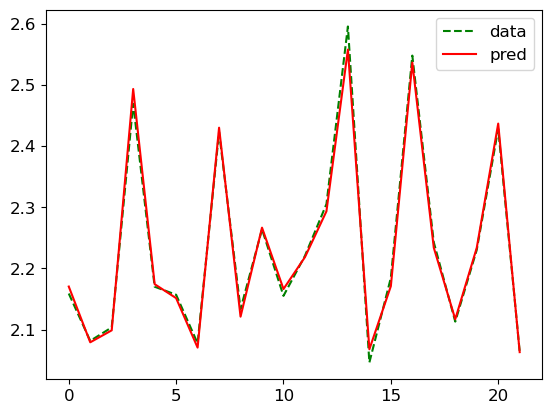

In [10]:
y_pr = best_model.predict(x_vl)
Y_pr = scaler_Y.inverse_transform(y_pr).flatten()
Y_vl = scaler_Y.inverse_transform(y_vl).flatten()
plt.plot(Y_vl, c='green', label='data', ls='--')
plt.plot(Y_pr, c='red', label='pred')
plt.legend()
plt.show()